In [1]:
import pandas as pd 
import numpy as np

import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt 

from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import StandardScaler

from sklearn import linear_model, neighbors, ensemble, tree

import warnings 
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('./input/final_test.csv')
data.head()

,weight,age,height,size
0,62,28.0,172.72,XL
1,59,36.0,167.64,L
2,61,34.0,165.10,M
3,65,27.0,175.26,L
4,62,45.0,172.72,M


In [3]:
data.isnull().sum()

weight      0
age       257
height    330
size        0
dtype: int64

In [4]:
data[['size']].value_counts()

size
M       29712
S       21924
XXXL    21359
XL      19119
L       17587
XXS      9964
XXL        69
dtype: int64

[]

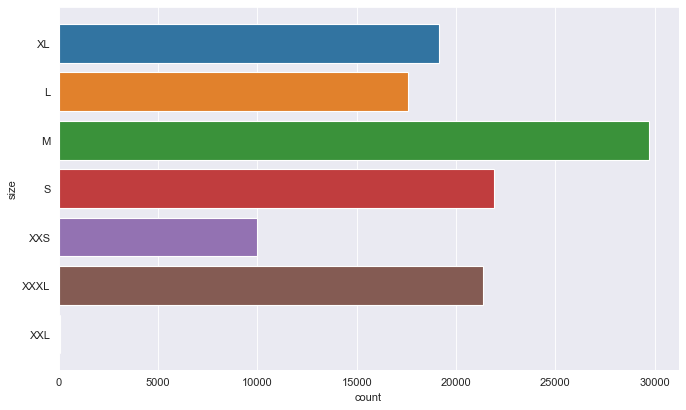

In [5]:
plt.figure(figsize=(10,6), dpi=80)
sns.countplot(y=data['size'])
plt.plot()

In [6]:
data.describe()

,weight,age,height
count,119734.000000,119477.000000,119404.000000
mean,61.756811,34.027311,165.805794
std,9.944863,8.149447,6.737651
min,22.000000,0.000000,137.160000
25%,55.000000,29.000000,160.020000
50%,61.000000,32.000000,165.100000
75%,67.000000,37.000000,170.180000
max,136.000000,117.000000,193.040000


In [7]:
data['age'] = data['age'].replace(0, np.nan)
data['age'] = data['age'].fillna(data['age'].median())

In [8]:
data[data['size'] == 'XXL'].isnull().sum() 

weight    0
age       0
height    0
size      0
dtype: int64

In [9]:
data.dropna(inplace=True)
data.isnull().sum()

weight    0
age       0
height    0
size      0
dtype: int64

In [10]:
data.reset_index(drop=True, inplace=True)

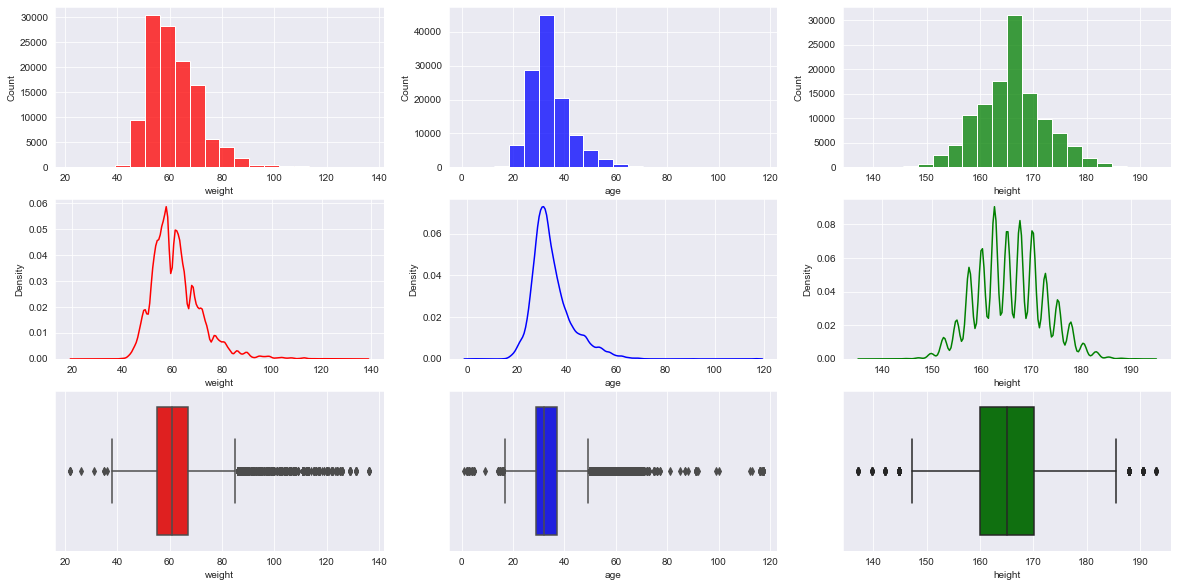

In [11]:
fig, ax = plt.subplots(figsize=(20,10), nrows=3, ncols=3)
colors = ['red', 'blue', 'green']

col_no = 0
for col in data.columns[:-1]:
    sns.histplot(x=col, data=data, ax=ax[0, col_no], bins=20, color=colors[col_no])
    sns.kdeplot(x=col, data=data, ax=ax[1, col_no], color=colors[col_no])
    sns.boxplot(x=col, data=data, ax=ax[2, col_no], color=colors[col_no])
    col_no += 1

In [12]:
data['size'].value_counts()

M       29638
S       21874
XXXL    21303
XL      19065
L       17529
XXS      9926
XXL        69
Name: size, dtype: int64

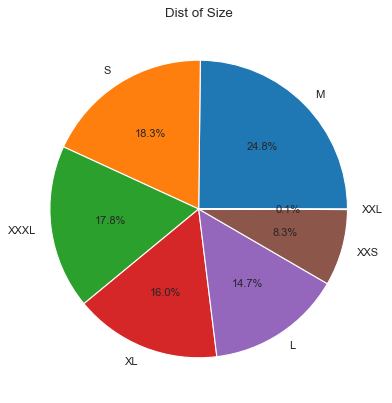

In [13]:
labels = list(data['size'].value_counts().index)

plt.figure(figsize=(6,8), dpi=80)
plt.pie(data['size'].value_counts(), autopct='%.1f%%', labels=labels)
plt.title('Dist of Size')
plt.show()

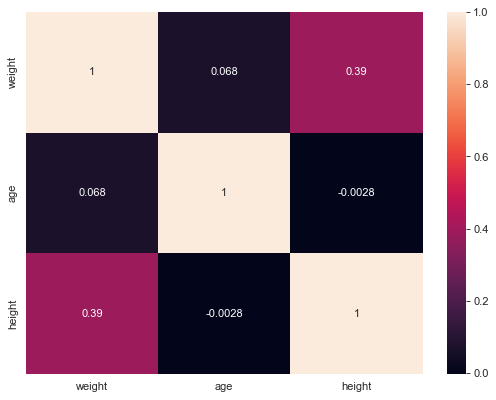

In [14]:
plt.figure(figsize=(8,6), dpi=80)
sns.heatmap(data.corr(), annot=True)
plt.show()

In [15]:
data['height_bins'] = pd.qcut(data['height'], q=6)
data['weight_bins'] = pd.qcut(data['weight'], q=10)
data['age_bins'] = pd.qcut(data['age'], q=10)

data.drop(['weight', 'age', 'height'], axis=1, inplace=True)
data.head()

,size,height_bins,weight_bins,age_bins
0,XL,"(167.64, 172.72]","(61.0, 63.0]","(26.0, 28.0]"
1,L,"(165.1, 167.64]","(58.0, 61.0]","(34.0, 36.0]"
2,M,"(162.56, 165.1]","(58.0, 61.0]","(32.0, 34.0]"
3,L,"(172.72, 193.04]","(63.0, 65.0]","(26.0, 28.0]"
4,M,"(167.64, 172.72]","(61.0, 63.0]","(39.0, 45.0]"


In [16]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data['size']):
    train = data.loc[train_index]
    test = data.loc[test_index]

In [17]:
train.shape, test.shape

((95523, 4), (23881, 4))

In [19]:
X_train = train.drop('size', axis=1)
y_train = train['size']

X_test = test.drop('size', axis=1)
y_test = test['size']

In [20]:
X_train = pd.get_dummies(X_train).values
X_test = pd.get_dummies(X_test).values

In [24]:
MLA_compare = pd.DataFrame()

def MLA_testing(MLA, X_train, X_test):
    row_index = 0
    for classifier in MLA:
        # Training The Model
        classifier.fit(X_train, y_train)

        # KFold Accuracies on Training Data
        kfold_accuracy = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10, n_jobs=-1)
        
        # Prediction on Testing Data
        y_pred = cross_val_predict(estimator = classifier, X = X_test, y = y_test, cv = 10, n_jobs=-1)
        
        # Accuracy for y_test and y_pred
        classifier_accuracy_score = accuracy_score(y_test, y_pred)

        # Saving Data in Dataframe
        MLA_name = classifier.__class__.__name__
        MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
        MLA_compare.loc[row_index, 'Accuracy Score'] = classifier_accuracy_score*100
        MLA_compare.loc[row_index, 'K-Fold Accuracy'] = kfold_accuracy.mean()*100

        print(MLA_name, "Done")
        row_index+=1

In [25]:
MLA = [
    ensemble.AdaBoostClassifier(), 
    ensemble.RandomForestClassifier(n_jobs=-1), 
    
    linear_model.RidgeClassifierCV(), 
    linear_model.SGDClassifier(n_jobs=-1), 
    
    neighbors.KNeighborsClassifier(), 
    
    tree.DecisionTreeClassifier(), 
    tree.ExtraTreeClassifier()
]

In [26]:
MLA_testing(MLA=MLA, X_train=X_train, X_test=X_test)

AdaBoostClassifier Done
RandomForestClassifier Done
RidgeClassifierCV Done
